In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import time
import math

# Votre premier transformer

Nous allons implementer de zero en Pytorch chaque composant d'un transformer 


* Le transformer que nous allons implementer est le transformer original presenté dans le papier "Attention is All you Need." Nous allons implementer au fur et à chaque composant. Le td est en 2 parties : Une partie sur la création d'un transformer, puis une partie sur l'entrainement qui permettra d'entrainer des transformers sur des données textuelles.

![Transformers Architecture](https://i0.wp.com/i.postimg.cc/Bn7QmpQS/1-43lg-CTy-M5c-TTABj-C2-VEHd-A.png?resize=579%2C800&ssl=1)




## Inputs Embeddings

https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html

In [3]:
from torch import nn
import torch

class InputEmbedding(nn.Module):
    def __init__(self, num_embeddings:int, embedding_dim:int):
        
        super(InputEmbedding,self).__init__()
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.layer_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)

        
    def forward(self,x):
        output = self.layer_embedding(x)
        return output

In [4]:
num_embedding=5000
embedding_dim = 784
sequence_length = 512
n_samples = 10

x = torch.randint(20,(n_samples,sequence_length))

token_embedding = InputEmbedding(num_embedding,embedding_dim)
token_embedding(x).shape

torch.Size([10, 512, 784])

## Positional Encoding

$$P(k,2i)= sin(\frac{k}{n^{2i/d}})$$
$$P(k,2i+1)= cos(\frac{k}{n^{(2i+1)/d}})$$
* k : longeur du contexte
* d : taille de l'embedding
* n : 10000 , hyperparamètre
* $i \in [0, d/2]$

In [5]:
class PositionalEmbedding(nn.Module):
    def __init__(self, seq_length:int, embedding_dim:int):
        
        self.seq_length = seq_length
        self.embedding_dim = embedding_dim
        self.n_param = 10000
        self.positions = torch.arange(0, self.seq_length).unsqueeze_(1)
        self.positional_embeddings = torch.zeros(self.seq_length, self.embedding_dim)

        denominators = torch.pow(self.n_param, 2*torch.arange(0, self.embedding_dim//2)/self.embedding_dim)
        self.positional_embeddings[:, 0::2] = torch.sin(self.positions/denominators)
        self.positional_embeddings[:, 1::2] = torch.cos(self.positions/denominators)
        
    def forward(self,x):
        return self.positional_embeddings[x, :]
        

In [6]:
import matplotlib.pyplot as plt

def display_positional_embedding(positional_embedding):
    plt.imshow(positional_embedding.positional_embeddings,cmap='viridis')
    plt.show()
    

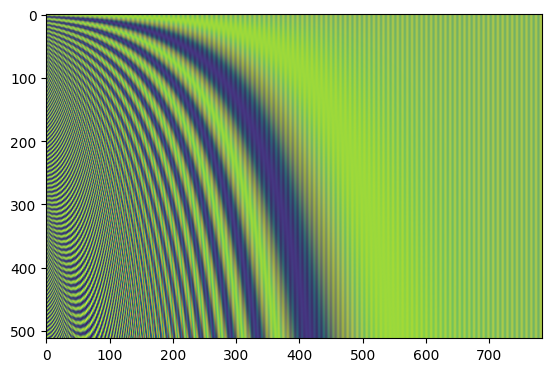

In [7]:
import time

tic = time.time()
pe=PositionalEmbedding(sequence_length,embedding_dim)
toc = time.time()
display_positional_embedding(pe)

## Multihead Attention
![Multi- Head Attention](https://i0.wp.com/i.postimg.cc/G23vwqn4/Screenshot-from-2019-06-17-22-47-53.webp?w=1230&ssl=1)

### Define a simple attention head
* https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
* https://pytorch.org/docs/stable/generated/torch.matmul.html
* https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html

In [10]:
class SelfAttention(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, out_dim = 0):
        super(SelfAttention, self).__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim

        if out_dim == 0:
            self.out_dim = embedding_dim

        self.query = nn.Linear(embedding_dim, hidden_dim, bias=False)
        self.key = nn.Linear(embedding_dim, hidden_dim, bias=False)
        self.value = nn.Linear(embedding_dim, out_dim, bias=False)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):

        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)

        scores = torch.matmul(queries, keys.transpose(1, 2))/(self.embedding_dim**0.5)
        attention = self.softmax(scores)
        out = torch.matmul(attention, values)
        return out, attention

In [11]:
x = torch.rand((11,10,784))
sa_module = SelfAttention(784,10)
out, attention = sa_module(x)
out.shape , attention.shape
attention

c:\Users\natha\Documents\Git\5th-year-polytech\transformers\env\Lib\site-packages\torch\nn\init.py:582: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


tensor([[[0.0999, 0.0996, 0.0999,  ..., 0.1004, 0.1005, 0.0989],
         [0.0997, 0.1000, 0.0996,  ..., 0.1006, 0.1004, 0.0992],
         [0.0997, 0.0995, 0.0997,  ..., 0.1003, 0.1002, 0.0993],
         ...,
         [0.0992, 0.0996, 0.1002,  ..., 0.1003, 0.1002, 0.0992],
         [0.0996, 0.0996, 0.1001,  ..., 0.1005, 0.1005, 0.0993],
         [0.1001, 0.0999, 0.0990,  ..., 0.1009, 0.1000, 0.0994]],

        [[0.1004, 0.0998, 0.1003,  ..., 0.1000, 0.1003, 0.1004],
         [0.1008, 0.0999, 0.1001,  ..., 0.0996, 0.1007, 0.1008],
         [0.1009, 0.0992, 0.0998,  ..., 0.0998, 0.1005, 0.1013],
         ...,
         [0.1003, 0.1002, 0.1009,  ..., 0.1003, 0.1001, 0.1006],
         [0.1004, 0.0999, 0.1001,  ..., 0.0998, 0.1006, 0.1007],
         [0.1007, 0.0997, 0.1000,  ..., 0.0999, 0.1002, 0.1010]],

        [[0.1005, 0.0996, 0.0996,  ..., 0.1001, 0.0999, 0.0997],
         [0.0999, 0.0996, 0.0999,  ..., 0.1002, 0.0997, 0.1001],
         [0.0998, 0.0999, 0.0993,  ..., 0.1001, 0.1003, 0.

### Masked MultiHead Attention
* https://pytorch.org/docs/stable/generated/torch.Tensor.masked_fill_.html
* https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html

In [24]:
class MaskedSelfAttention(SelfAttention):
    def __init__(self, embedding_dim: int, hidden_dim:int,out_dim : int = 0):
        super(MaskedSelfAttention,self).__init__(embedding_dim,hidden_dim,out_dim)
        
    def forward(self,x):

        B, T, C = x.size()

        print(T)

        mask = torch.triu(torch.ones(T, T), diagonal=1).bool()
        
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)

        scores = torch.matmul(queries, keys.transpose(1, 2))/(self.embedding_dim**0.5)
        scores = scores.masked_fill_(mask, float("-inf"))
        attention = self.softmax(scores)
        out = torch.matmul(attention, values)

        return out, attention

In [25]:
x = torch.rand((11,10,784))
sa_module = MaskedSelfAttention(784,10)
out, attention = sa_module(x)
out.shape , attention.shape
attention

10


tensor([[[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.5004, 0.4996, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3317, 0.3326, 0.3357,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1246, 0.1247, 0.1271,  ..., 0.1253, 0.0000, 0.0000],
         [0.1110, 0.1111, 0.1123,  ..., 0.1115, 0.1108, 0.0000],
         [0.0998, 0.0998, 0.1013,  ..., 0.1006, 0.1003, 0.0993]],

        [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.5009, 0.4991, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3338, 0.3354, 0.3308,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.1253, 0.1266, 0.1238,  ..., 0.1245, 0.0000, 0.0000],
         [0.1126, 0.1113, 0.1102,  ..., 0.1106, 0.1100, 0.0000],
         [0.1008, 0.1004, 0.0995,  ..., 0.1000, 0.0991, 0.1002]],

        [[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.5022, 0.4978, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.3358, 0.3292, 0.3350,  ..., 0.0000, 0.0000, 0.

### Define multihead attention

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        attn_probs = F.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, num_heads, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, x):
        Q = self.split_heads(self.W_q(x))
        K = self.split_heads(self.W_k(x))
        V = self.split_heads(self.W_v(x))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V)
        output = self.W_o(self.combine_heads(attn_output))
        return output, attn_output

In [33]:
embedding_dim = 784
n_heads = 4
hidden_dimension = 784
context_lenght = 10
bs = 11
mha = MultiHeadAttention(embedding_dim,n_heads)
x = torch.rand((bs,context_lenght,embedding_dim))
out, attention = mha(x)
out.shape , attention.shape

(torch.Size([11, 10, 784]), torch.Size([11, 4, 10, 196]))

## Masked Multihead Attention

In [ ]:
class MaskedMultiHeadAttention(MultiHeadAttention):
    def __init__(self, embedding_dim : int , n_head :int, hidden_dimension : int ):
        super(MaskedMultiHeadAttention, self).__init__(embedding_dim,n_head,hidden_dimension)
        

In [ ]:
embedding_dim = 784
n_heads = 16
hidden_dimension = 784
context_lenght = 10
bs = 11
mha = MaskedMultiHeadAttention(embedding_dim,n_heads,hidden_dimension)
x = torch.rand((bs,context_lenght,embedding_dim))
out, attention = mha(x)
out.shape , attention.shape

## Cross MultiHead Attention

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, embedding_dim: int, hidden_dimension:int, out_dim : int = 0  ):
        super(CrossAttention,self).__init__()
        

In [ ]:
class CrossMultiHeadAttention(MultiHeadAttention):
    def __init__(self, embedding_dim : int , n_head :int, hidden_dimension : int ):
    
    def forward(self,x,context):
        
        return out , out_attention

In [ ]:
embedding_dim = 784
n_heads = 16
hidden_dimension = 784
context_lenght = 10
bs = 11
cha = CrossMultiHeadAttention(embedding_dim,n_heads,hidden_dimension)
x = torch.rand((bs,context_lenght,embedding_dim))
context = torch.rand((bs,context_lenght//2,embedding_dim))
out, attention = cha(x,context)
out.shape , attention.shape



## Feed Forward Layer

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, embedding_dim, hidden_dim):
        

    def forward(self, x):
        return 


## Block

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, embedding_dim: int,
                 qk_hidden_dimension:int,
                 feedforward_hidden_dimension : int,
                 n_heads : int   ):
        super(EncoderBlock, self).__init__()
        
       
        
    def forward(self,x):
        
        return out, att1
        
        

In [ ]:
embedding_dim = 784
n_heads = 16
hidden_dimension = 784
context_lenght = 10
bs = 11
n_blocks  = 5
vocab_size = 3000
context_size = 40
enc_bloc = EncoderBlock(embedding_dim,hidden_dimension,hidden_dimension,n_heads)
x = torch.rand((bs,context_lenght,embedding_dim))
enc , attn = enc_bloc(x)
enc.shape , attn.shape

## Encoder

In [ ]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim: int,
                 qk_hidden_dimension:int,
                 feedforward_hidden_dimension : int,
                 n_heads : int ,
                n_blocks : int,
                vocab_size : int,
                context_size : int):
        super(TransformerEncoder, self).__init__()
        
        
    def forward(self,x):
        
        return x , attns
                                    
                                               

In [ ]:
encoder = TransformerEncoder(embedding_dim,hidden_dimension,hidden_dimension,n_heads,n_blocks,vocab_size, context_size)
x = torch.randint(20,(10,10))
encoding , attns = encoder(x)
encoding.shape , len(attns), attns[0].shape

## Decoder

# A vous de jouer

En reutilisant au maximum les composants au dessus, implementer le decodeur et le transformeur final

## Transformer

